# Bernstein-Vazirani algorithm

This algorithm aims at finding a secret number with only one query to an oracle function.

In this notebook, we will try to find a secret number that can be represented with at most 5 bits with this algorithm.

In [1]:
secret_number = 4 # because 4 and because 4 = 0b100
nb_qubits = 3

In [2]:
# imports
%matplotlib inline
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer import noise
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [3]:
# Loadi IBM Q account
provider = IBMQ.load_account()

## Turn the secret number to a quantum circuit

The first step is to turn the secret number into a circuit of quantum gates.

There are two ways to do so:
* with Z gates
* with CNOT gates

In [4]:
def build_secret_circuit_z(number: int, nb_qubits: int = nb_qubits) -> QuantumCircuit:
    """
    Return a QuantumCircuit representing the secret number with Z gates on nb_qubits qubits.
    
    :param number: the secret number
    :param nb_qubits: the number of qubits to represent the secret number on
    """
    if(number >= 2**nb_qubits):
        raise ValueError(f"{number} cannot be represented on {nb_qubits} qubits.")
    # turn each 1 in the binary representation of the number to a Z gate
    sub_circuit = QuantumCircuit(nb_qubits, name="secret_number_z")
    for i in range(nb_qubits):
        if(number & (1 << i)):
            sub_circuit.z(i)
    return sub_circuit

In [5]:
def build_secret_circuit_cnot(number: int, nb_qubits: int = nb_qubits + 1) -> QuantumCircuit:
    """
    Return a QuantumCircuit representing the secret number with CNOT gates on nb_qubits qubits.
    This circuit needs an ancilla qubit.
    
    :param number: the secret number
    :param nb_qubits: the number of qubits to represent the secret number on (+1 ancilla)
    """
    if(number >= 2**(nb_qubits - 1)):
        raise ValueError(f"{number} cannot be represented on {nb_qubits - 1} qubits.")
    # turn each 1 in the binary representation of the number to a CNOT gate controlling the ancilla qubit
    sub_circuit = QuantumCircuit(nb_qubits, name="secret_number_cnot")
    for i in range(nb_qubits):
        if(number & (1 << i)):
            sub_circuit.cnot(i, nb_qubits - 1)
    return sub_circuit

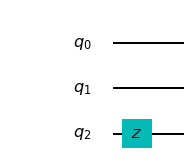

In [6]:
# Display the circuit that represents the secret number with Z gates
secret_number_sub_circuit_z = build_secret_circuit_z(secret_number, nb_qubits)
secret_number_sub_circuit_z.draw()

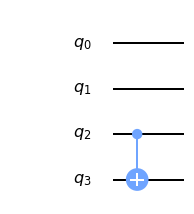

In [7]:
# Display the circuit that represents the secret number with CNOT gates
secret_number_sub_circuit_cnot = build_secret_circuit_cnot(secret_number, nb_qubits + 1)
secret_number_sub_circuit_cnot.draw()

## Build the circuit of the algorithm

The second step is know to build the circuit to guess this number.

We will build two circuit, one will use Z gates and the other one will use CNOT gates.

In [8]:
def build_bernstein_vazirani_circuit(oracle: QuantumCircuit, ancilla: bool = False) -> QuantumCircuit:
    """
    Return a Bernstein-Vazirani circuit to guess a secret number
    
    :param oracle: the secret number's circuit
    :param ancilla: True if the oracle uses an ancilla qubit initialized to |1>
    """
    nb_qubits = oracle.n_qubits
    circuit = QuantumCircuit(nb_qubits, nb_qubits)
    if(ancilla):
        circuit.x(nb_qubits - 1)
    circuit.h(range(nb_qubits))
    circuit.append(oracle.to_instruction(), range(nb_qubits))
    circuit.h(range(nb_qubits))
    if(ancilla):
        circuit.measure(range(nb_qubits - 1), range(nb_qubits - 1))
    else:
        circuit.measure(range(nb_qubits), range(nb_qubits))
    return circuit

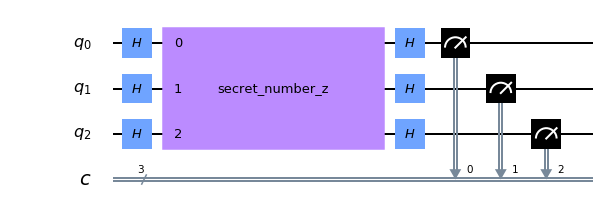

In [9]:
# Version with Z gates
bernstein_vazirani_circuit_z = build_bernstein_vazirani_circuit(secret_number_sub_circuit_z)
bernstein_vazirani_circuit_z.draw()

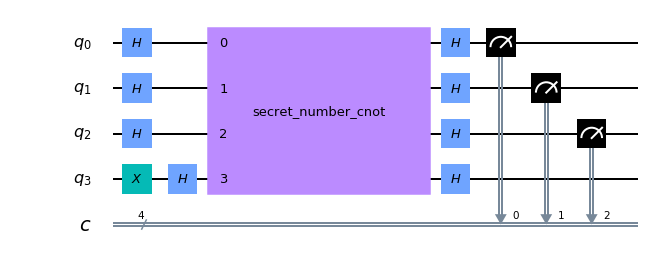

In [10]:
# Version with Z gates
bernstein_vazirani_circuit_cnot = build_bernstein_vazirani_circuit(secret_number_sub_circuit_cnot, True)
bernstein_vazirani_circuit_cnot.draw()

## Simulate the circuits

Now that we have designed the circuits, let us simulate them in perfect conditions.

In [11]:
simulator = Aer.get_backend('qasm_simulator')

In [12]:
def simulate_circuit(circuit):
    job = execute(circuit, backend=simulator, shots=1024)
    counts = job.result().get_counts(circuit)
    return counts

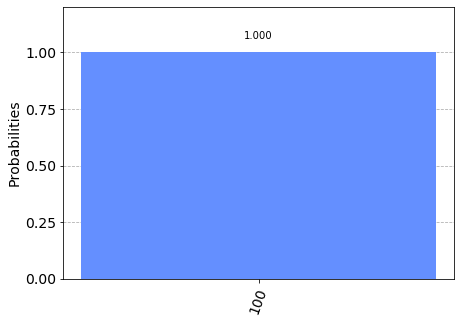

In [13]:
counts_z = simulate_circuit(bernstein_vazirani_circuit_z)
plot_histogram(counts_z)

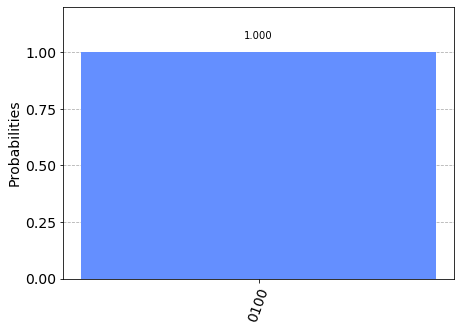

In [14]:
counts_cnot = simulate_circuit(bernstein_vazirani_circuit_cnot)
plot_histogram(counts_cnot)

### Retrieve the secret number

Now that we have the output, we can guess the number.

In [15]:
def counts2number(counts):
    return int(max(counts, key=counts.get), 2)

In [16]:
print(f"The secret number (with Z gates) is {counts2number(counts_z)}.")
print(f"The secret number (with CNOT gates) is {counts2number(counts_cnot)}.")

The secret number (with Z gates) is 4.
The secret number (with CNOT gates) is 4.


## Simulate the circuits with a real device configuration

The perfect simulation is too perfect to be realistic.
Hence, we will simulate a given real quantum device before runnig the algorithm on this device.
We aim at simulating the noise of the device.

In [17]:
device = least_busy(provider.backends(filters=lambda b: not b.configuration().simulator
                                              and b.status().operational
                                              and b.configuration().n_qubits >= nb_qubits))
print(device)

ibmqx2


In [18]:
properties = device.properties()
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(properties)
basis_gates = noise_model.basis_gates

/opt/conda/lib/python3.7/site-packages/qiskit/providers/aer/noise/device/basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


In [19]:
def simulate_circuit_with_noise(circuit):
    job = execute(circuit, backend=simulator, shots=1024,
                    noise_model=noise_model,
                    coupling_map=coupling_map,
                    basis_gates=basis_gates)
    counts = job.result().get_counts(circuit)
    return counts

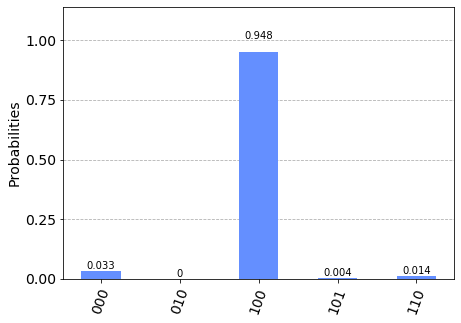

In [20]:
counts_noise_z = simulate_circuit_with_noise(bernstein_vazirani_circuit_z)
plot_histogram(counts_noise_z)

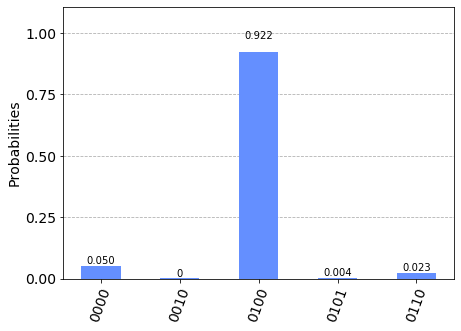

In [21]:
counts_noise_cnot = simulate_circuit_with_noise(bernstein_vazirani_circuit_cnot)
plot_histogram(counts_noise_cnot)

### Observations

This time, we can see that the results are, in both case, no longer perfect.
Even if the Bernstein-Vazirani algorithm only needs one shot to guess the secret number, the secret number is not always the output of the algorithm.
The algorithm may fail due to the noise and output the wrong value.
We can see that there is between 5% and 8% of errors.

In [22]:
# Retrieve the secret number
print(f"The secret number (with Z gates) is {counts2number(counts_noise_z)}.")
print(f"The secret number (with CNOT gates) is {counts2number(counts_noise_cnot)}.")

The secret number (with Z gates) is 4.
The secret number (with CNOT gates) is 4.


## Run the circuit on the real quantum device

Let uss compare the simulated results (both with and without noise) with the ones from a real noisy device from the NISQ era.

NISQ = Noisy Intermidiate-Scale Quantum

In [23]:
def run_circuit(circuit):
    job = execute(circuit, backend=device, shots=1024)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts, result

Job Status: job has successfully run


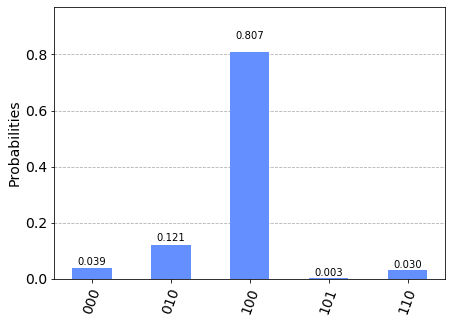

In [24]:
counts_device_z, result_device_z = run_circuit(bernstein_vazirani_circuit_z)
plot_histogram(counts_device_z)

Job Status: job has successfully run


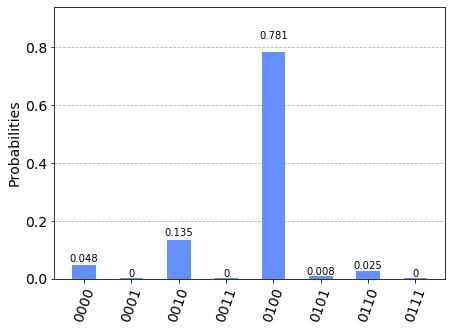

In [25]:
counts_device_cnot, result_device_cnot = run_circuit(bernstein_vazirani_circuit_cnot)
plot_histogram(counts_device_cnot)

In [26]:
# Retrieve the secret number
print(f"The secret number (with Z gates) is {counts2number(counts_device_z)}.")
print(f"The secret number (with CNOT gates) is {counts2number(counts_device_cnot)}.")

The secret number (with Z gates) is 4.
The secret number (with CNOT gates) is 4.


### Mitigate the noise of the device

Even though the results are quite good.
We got even more noise than expected.
Let us try to reduce this noise.

In [27]:
# Calibration of the device
calibration_circuits, state_labels = complete_meas_cal(qubit_list=range(nb_qubits), circlabel='measurement_calibration')
calibration_jobs = execute(calibration_circuits, backend=device, shots=1024*4, optimization_level=0)
job_monitor(calibration_jobs)
calibration_results = calibration_jobs.result()
measurement_fitter = CompleteMeasFitter(calibration_results, state_labels)
measurement_filter_z = measurement_fitter.filter

Job Status: job has successfully run


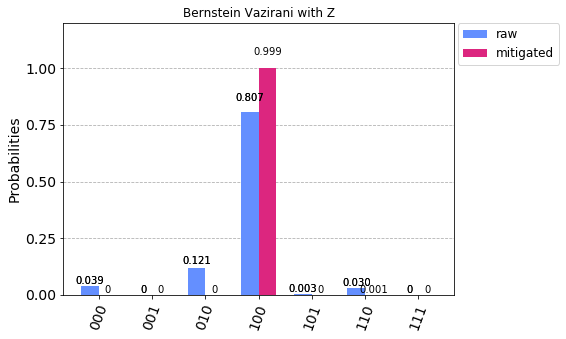

In [28]:
# Mitigate the noise
mitigated_result_z = measurement_filter_z.apply(result_device_z)
mitigated_counts_z = mitigated_result_z.get_counts(bernstein_vazirani_circuit_z)

# Compare noisy and mitigated results
plot_histogram([counts_device_z, mitigated_counts_z], legend=['raw', 'mitigated'],
               title='Bernstein Vazirani with Z')

In [29]:
# Calibration of the device (for one more qubit)
calibration_circuits, state_labels = complete_meas_cal(qubit_list=range(nb_qubits + 1), circlabel='measurement_calibration_cnot')
calibration_jobs = execute(calibration_circuits, backend=device, shots=1024*4, optimization_level=0)
job_monitor(calibration_jobs)
calibration_results = calibration_jobs.result()
measurement_fitter = CompleteMeasFitter(calibration_results, state_labels)
measurement_filter_cnot = measurement_fitter.filter

Job Status: job has successfully run


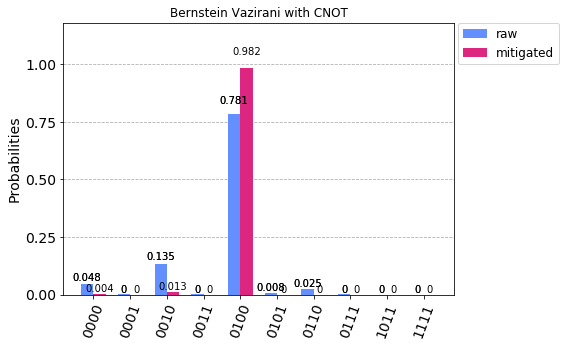

In [30]:
# Mitigate the noise
mitigated_result_cnot = measurement_filter_cnot.apply(result_device_cnot)
mitigated_counts_cnot = mitigated_result_cnot.get_counts(bernstein_vazirani_circuit_cnot)

# Compare noisy and mitigated results
plot_histogram([counts_device_cnot, mitigated_counts_cnot], legend=['raw', 'mitigated'],
               title='Bernstein Vazirani with CNOT')

### Observation

After mitigation, the results are better with mitigated noise than simulated noise.
From about 20% of error, we jump to less than 2% of error after mitigation.

In [31]:
# Retrieve the secret number
print(f"The secret number (with Z gates) is {counts2number(mitigated_counts_z)}.")
print(f"The secret number (with CNOT gates) is {counts2number(mitigated_counts_cnot)}.")

The secret number (with Z gates) is 4.
The secret number (with CNOT gates) is 4.


## Conclusion

We saw that the Bernstein-Vazirani algorithm behaved as expected to find in one shot a secret number turned into a quantum circuit.

Moreover, we used the Aer submodule of Qiskit to simulate the noise of the real device then we used the Ignis submodule of Qiskit to mitigate the noise produced by the real quantum computers.